# Using Tensor contraction to store geological model objects

## _=*KRUTYE*=_

Daniil Sherki, Egor Cherepanov, Egor Malkershin

A three-dimensional geological model of a hydrocarbon reservoir is a three-dimensional representation of a reservoir in the form of a multidimensional object, which maximally reflects the geological structure of the object under study and is used to study the field production processes. As a result, a geological model is a copy of a real oil/gas field, but in the form of a set of cells of different size (often 5𝑚 × 5𝑚 × 1𝑚), the grid of cells stores various properties: saturation, permeability along the directions, porosity, etc.

Everything comes down to storing a large number of three-dimensional tensors and manipulating them. Due to small cell size in comparison with the size of the field itself, the number of cells can be large (11 trillion cells for the Gawar field, assuming that the cell size is 8𝑚 × 8𝑚 × 1𝑚).

Our first task is to represent the tensors of field properties: NTG, permeability, porosity, saturation of fluid in the form of compressed tensors, which can be restored with a certain error. The second task is to evaluate the quantity of this error and the applicability of this method to geological modeling.

We assume to use the following methods to compress tensors:

* Tensor-Train Decomposition
* Tucker decomposition

Sources:
1. Oseledets, Ivan. (2011). Tensor-Train Decomposition. SIAM J. Scientific Computing. 33. 2295-2317. 10.1137/090752286.

2. Tucker LR. Some mathematical notes on three-mode factor analysis. Psychometrika. 1966 Sep;31(3):279-311. doi: 10.1007/BF02289464. PMID: 5221127

In [1]:
import pandas as pd
import numpy as np

from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import sys

In [2]:
url_poro = 'https://raw.githubusercontent.com/sherkidanil/skoltech_st_works/main/porosity_spe10.csv'
url_perm = 'https://raw.githubusercontent.com/sherkidanil/skoltech_st_works/main/permeability_spe10.csv'

In [3]:
df = pd.read_csv(url_poro, delimiter=';')
poro_tensor = df.to_numpy()
poro_tensor = np.reshape(poro_tensor, [60,220,85])

In [4]:
df2 = pd.read_csv(url_perm, delimiter=';')
good_cols = ['col1', 'col2', 'col3',
             'col4','col5','col6']
perm_tensor = np.array(df2[good_cols])
perm_tensor = np.reshape(perm_tensor, [60,220,85])

In [90]:
def cubes_visualization(property_data, origin = (0,0,0), spacing = (20,10,2),
                        label = 'Property', cmap = 'Wistia', show_edges = False,
                        order = 'K', legend_scale = False, leg_sc_lims = [0.00001, 100]):
    # Create the 3D NumPy array of spatially referenced data
    # This is spatially referenced such that the grid is 20 by 5 by 10
    #   (nx by ny by nz)

    # Create the spatial reference

    grid = pv.UniformGrid()

    # Set the grid dimensions: shape because we want to inject our values on the
    #   POINT data

    grid.dimensions = property_data.shape

    # Edit the spatial reference
    grid.origin = origin # The bottom left corner of the data set
    grid.spacing = spacing  # These are the cell sizes along each axis

    # Add the data values to the cell data

    grid.point_data[label] = property_data.flatten(order = order)  # Flatten the array!

    # Now plot the grid!
    boring_cmap = plt.cm.get_cmap(cmap)
    grid = grid.flip_z()
    grid = grid.flip_x()
    if legend_scale:
        grid.plot(show_edges=show_edges, cmap = boring_cmap, clim=leg_sc_lims,
                  below_color='blue', above_color='red')
    else:
        grid.plot(show_edges=show_edges, cmap = boring_cmap)
    return grid

# poro_vis = cubes_visualization(poro_tensor, spacing=(20,20,10),
#                                origin = (100,100,100), label = 'Porosity')
# permx_vis = cubes_visualization(permx_tensor, label='Permeability, mD', cmap='RdBu_r',
#                                 legend_scale=True, leg_sc_lims=[20, 700],  spacing=(20,20,10))

In [5]:
poro_tensor.shape

(60, 220, 85)

In [6]:
#size of object in bytes
sys.getsizeof(poro_tensor)

136

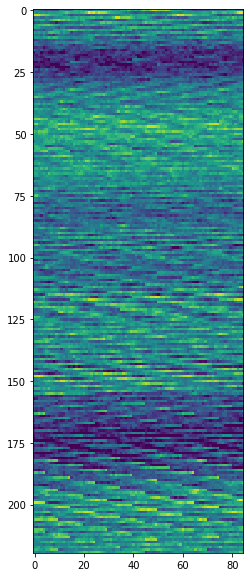

In [7]:
plt.figure(figsize=(10, 10))
plt.imshow(poro_tensor[0], interpolation='none')

# Decompositions

In [9]:
!pip install tntorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 3.4 MB/s 


In [10]:
import tntorch as tn
import torch
torch.set_default_dtype(torch.float64)
import time

In [11]:
def metrics(real, approx):
    print(approx)
    print('Compression ratio: {}/{} = {:g}'.format(real.numel(), approx.numcoef(), real.numel() / approx.numcoef()))
    print('Relative error:', tn.relative_error(real, approx))
    print('RMSE:', tn.rmse(real, approx))
    print('R^2:', tn.r_squared(real, approx))
    return()

In [12]:
poro_tensor = torch.from_numpy(poro_tensor)

torch.Size([60, 220, 85])


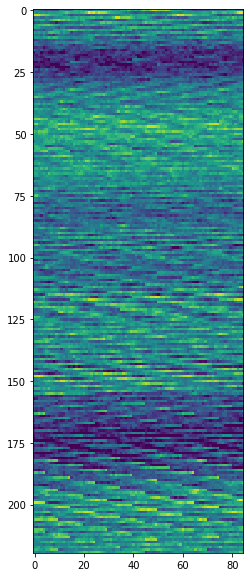

In [13]:
print(poro_tensor.shape)
plt.figure(figsize=(10, 10))
plt.imshow(poro_tensor[0], interpolation='none')

In [14]:
def numcoef(self):
        """
        Counts the total number of compressed coefficients of this tensor.
        :return: an integer
        """

        result = 0
        for n in range(self.dim()):
            result += self.cores[n].numel()
            if self.Us[n] is not None:
                result += self.Us[n].numel()
        return result

## Canonical Poliadic Decomposition

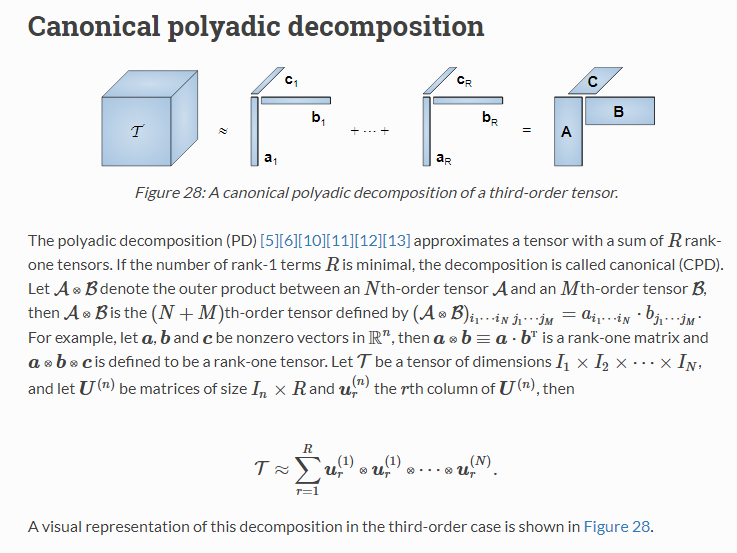

In [15]:
t = tn.Tensor(poro_tensor, ranks_cp=3, verbose=True)  # CP is computed using alternating least squares (ALS)
metrics(poro_tensor, t)

ALS -- initialization time = 0.46231675148010254
iter: 0  | eps: 0.45098561 | total time:    0.5556
iter: 1  | eps: 0.45086398 | total time:    0.6078
iter: 2  | eps: 0.45037914 | total time:    0.6602
iter: 3  | eps: 0.44753593 | total time:    0.7102
iter: 4  | eps: 0.44684395 | total time:    0.7462
iter: 5  | eps: 0.44652214 | total time:    0.7762
iter: 6  | eps: 0.44636267 | total time:    0.8187
iter: 7  | eps: 0.44625717 | total time:    0.8467
iter: 8  | eps: 0.44618072 | total time:    0.8802 <- converged (tol=0.0001)
3D CP tensor:

 60  220 85
  |   |   |
 <0> <1> <2>
 / \ / \ / \
3   3   3   3

Compression ratio: 1122000/1095 = 1024.66
Relative error: tensor(0.4462)
RMSE: tensor(0.0868)
R^2: tensor(0.1356)


()

In [16]:
poro_tensor.numel(), poro_tensor.shape[0]*poro_tensor.shape[1]*poro_tensor.shape[2]

(1122000, 1122000)

In [17]:
t.numcoef(), t.cores[0].shape[0]*t.cores[0].shape[1] + t.cores[1].shape[0]*t.cores[1].shape[1] + t.cores[2].shape[0]*t.cores[2].shape[1]

(1095, 1095)

In [18]:
t.cores[0].shape,t.cores[1].shape,t.cores[2].shape

(torch.Size([60, 3]), torch.Size([220, 3]), torch.Size([85, 3]))

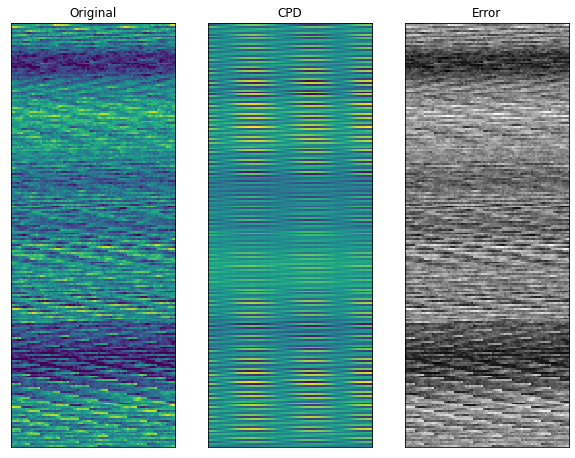

In [19]:
plt.figure(figsize=(10,10))

plt.subplot(131),plt.imshow(poro_tensor[0], interpolation='none'),plt.title('Original')
plt.xticks([]), plt.yticks([])


plt.subplot(132),plt.imshow(t.numpy()[0], interpolation='none'),plt.title('CPD')
plt.xticks([]), plt.yticks([])

plt.subplot(133),plt.imshow((poro_tensor[0]-t.numpy()[0]), interpolation='none',cmap='gray'),plt.title('Error')
plt.xticks([]), plt.yticks([])

plt.show()

In [20]:
np.logspace(1,3,5)

array([  10.        ,   31.6227766 ,  100.        ,  316.22776602,
       1000.        ])

In [21]:
compression_ratio_CPD = []
relative_error_CPD = []
RMSE_CPD = []
r2_CPD = []
real = poro_tensor
i_mem_CPD = []
t_mem_CPD = []
for i in np.int32(np.logspace(1,3,50)):
  t_CPD = tn.Tensor(poro_tensor, ranks_cp=i, verbose=True)  # CP is computed using alternating least squares (ALS)
  approx_CPD = t_CPD
  compression_ratio_CPD.append(approx_CPD.numcoef() / real.numel())
  relative_error_CPD.append(tn.relative_error(real, approx_CPD))
  RMSE_CPD.append(tn.rmse(real, approx_CPD))
  r2_CPD.append(tn.r_squared(real, approx_CPD))
  t_mem_CPD.append(t_CPD)
  i_mem_CPD.append(i)

ALS -- initialization time = 0.0485687255859375
iter: 0  | eps: 0.44898082 | total time:    0.0803
iter: 1  | eps: 0.44447556 | total time:    0.1012
iter: 2  | eps: 0.43496762 | total time:    0.1230
iter: 3  | eps: 0.42689571 | total time:    0.1442
iter: 4  | eps: 0.42203215 | total time:    0.1651
iter: 5  | eps: 0.41994182 | total time:    0.1880
iter: 6  | eps: 0.41902990 | total time:    0.2145
iter: 7  | eps: 0.41842076 | total time:    0.2354
iter: 8  | eps: 0.41814936 | total time:    0.2603
iter: 9  | eps: 0.41800609 | total time:    0.2823
iter: 10 | eps: 0.41789475 | total time:    0.3044
iter: 11 | eps: 0.41779594 | total time:    0.3316 <- converged (tol=0.0001)
ALS -- initialization time = 0.042856454849243164
iter: 0  | eps: 0.44898082 | total time:    0.0728
iter: 1  | eps: 0.44447556 | total time:    0.0965
iter: 2  | eps: 0.43496762 | total time:    0.1194
iter: 3  | eps: 0.42689571 | total time:    0.1441
iter: 4  | eps: 0.42203215 | total time:    0.1655
iter: 5  

In [ ]:
# compression_ratio
# relative_error
# RMSE
# r2

[307.3972602739726]

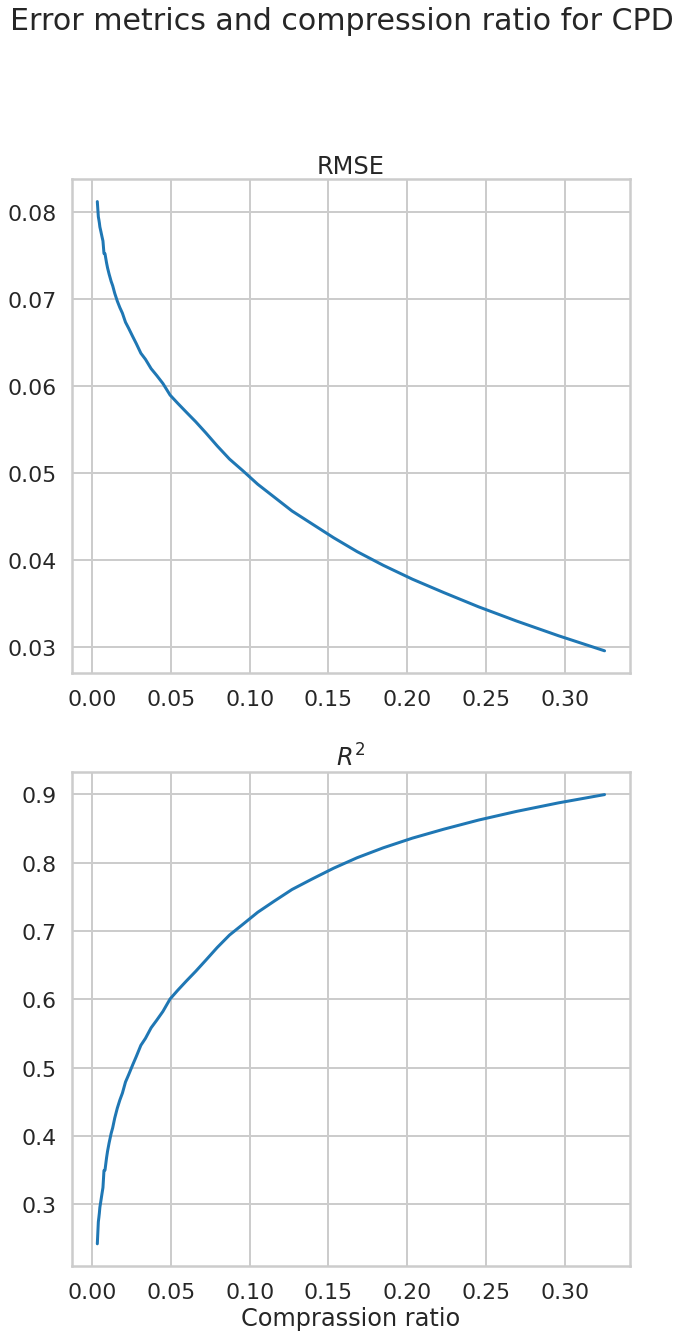

In [83]:
plt.figure(figsize=(10,20))

plt.subplot(211)
plt.plot(compression_ratio_CPD, RMSE_CPD)
plt.title('RMSE')
ax = plt.gca()

plt.subplot(212)
plt.plot(compression_ratio_CPD, r2_CPD)
plt.title('$R^2$')
ax = plt.gca()

ax.set_xlabel('Comprassion ratio')

plt.suptitle('Error metrics and compression ratio for CPD', fontsize = 30, y=1)

plt.savefig('saved_figure_CPD.png')

plt.show()

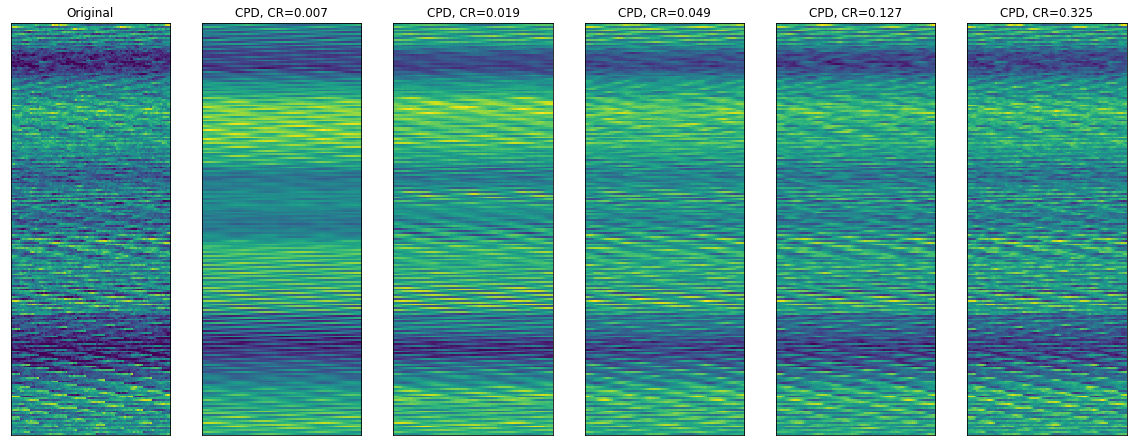

In [30]:
plt.figure(figsize=(20,10))

plt.subplot(161),plt.imshow(poro_tensor[0], interpolation='none')
plt.title('Original')
plt.xticks([]), plt.yticks([])

plt.subplot(162),plt.imshow(t_mem_CPD[9].numpy()[0], interpolation='none')
plt.title('CPD, CR='+str(round(compression_ratio_CPD[9],3)))
plt.xticks([]), plt.yticks([])

plt.subplot(163),plt.imshow(t_mem_CPD[19].numpy()[0], interpolation='none')
plt.title('CPD, CR='+str(round(compression_ratio_CPD[19],3)))
plt.xticks([]), plt.yticks([])

plt.subplot(164),plt.imshow(t_mem_CPD[29].numpy()[0], interpolation='none')
plt.title('CPD, CR='+str(round(compression_ratio_CPD[29],3)))
plt.xticks([]), plt.yticks([])

plt.subplot(165),plt.imshow(t_mem_CPD[39].numpy()[0], interpolation='none')
plt.title('CPD, CR='+str(round(compression_ratio_CPD[39],3)))
plt.xticks([]), plt.yticks([])

plt.subplot(166),plt.imshow(t_mem_CPD[49].numpy()[0], interpolation='none')
plt.title('CPD, CR='+str(round(compression_ratio_CPD[49],3)))
plt.xticks([]), plt.yticks([])

plt.show()

## Tucker decomposition

In [31]:
t = tn.Tensor(poro_tensor, ranks_tucker=3) 
metrics(poro_tensor, t)

3D TT-Tucker tensor:

 60  220 85
  |   |   |
  3   3   3
 (0) (1) (2)
 / \ / \ / \
1   9   3   1

Compression ratio: 1122000/1212 = 925.743
Relative error: tensor(0.4415)
RMSE: tensor(0.0859)
R^2: tensor(0.1535)


()

In [32]:
t.cores[0].shape,t.cores[1].shape,t.cores[2].shape

(torch.Size([1, 3, 9]), torch.Size([9, 3, 3]), torch.Size([3, 3, 1]))

In [33]:
sys.getsizeof(poro_tensor), sys.getsizeof(t)

(72, 48)

In [34]:
compression_ratio_TUC = []
relative_error_TUC = []
RMSE_TUC = []
r2_TUC = []
real = poro_tensor
i_mem_TUC = []
t_mem_TUC = []
for i in np.int32(np.linspace(1,250,50)):
  t_TUC = tn.Tensor(poro_tensor, ranks_tucker=i)   # CP is computed using alternating least squares (ALS)
  approx_TUC = t_TUC
  compression_ratio_TUC.append(approx_TUC.numcoef() / real.numel())
  relative_error_TUC.append(tn.relative_error(real, approx_TUC))
  RMSE_TUC.append(tn.rmse(real, approx_TUC))
  r2_TUC.append(tn.r_squared(real, approx_TUC))
  t_mem_TUC.append(t_TUC)
  i_mem_TUC.append(i)

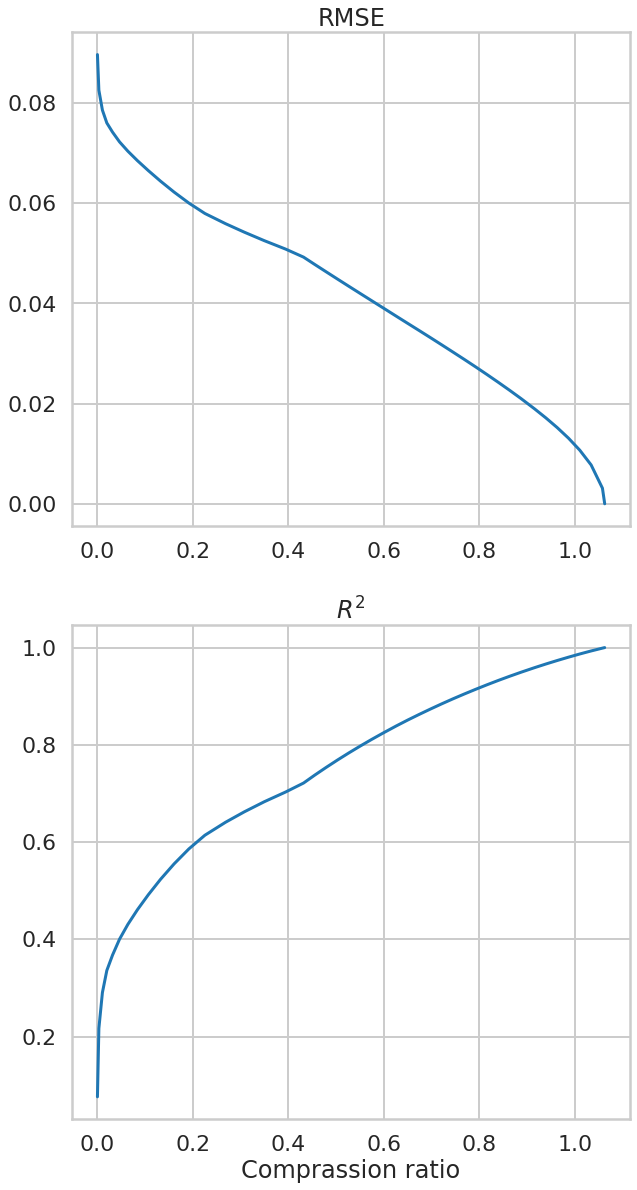

In [86]:
plt.figure(figsize=(10,20))

plt.subplot(211)
plt.plot(compression_ratio_TUC, RMSE_TUC)
plt.title('RMSE')
ax = plt.gca()

plt.subplot(212)
plt.plot(compression_ratio_TUC, r2_TUC)
plt.title('$R^2$')
ax = plt.gca()

ax.set_xlabel('Comprassion ratio')

plt.suptitle('Error metrics and compression ratio for Tucker Decomposition', fontsize = 20, y=1)

plt.savefig('saved_figure_TD.png')
plt.show()

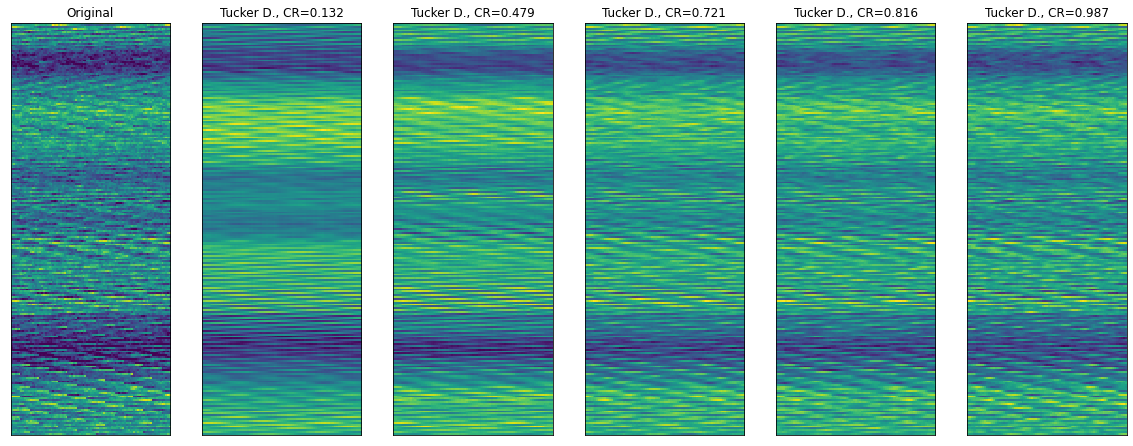

In [42]:
title_TUC = 'Tucker D., CR='

plt.figure(figsize=(20,10))

plt.subplot(161)
plt.imshow(poro_tensor[0], interpolation='none')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(162)
plt.imshow(t_mem_CPD[9].numpy()[0], interpolation='none')
plt.title(title_TUC+str(round(compression_ratio_TUC[9],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(163)
plt.imshow(t_mem_CPD[19].numpy()[0], interpolation='none')
plt.title(title_TUC+str(round(compression_ratio_TUC[19],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(164)
plt.imshow(t_mem_CPD[29].numpy()[0], interpolation='none')
plt.title(title_TUC+str(round(compression_ratio_TUC[29],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(165)
plt.imshow(t_mem_CPD[33].numpy()[0], interpolation='none')
plt.title(title_TUC+str(round(compression_ratio_TUC[33],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(166)
plt.imshow(t_mem_CPD[40].numpy()[0], interpolation='none')
plt.title(title_TUC+str(round(compression_ratio_TUC[40],3)))
plt.xticks([])
plt.yticks([])

plt.show()

## Tensor - Train Decomposition

In [43]:
t = tn.Tensor(poro_tensor, ranks_tt=3) 
metrics(poro_tensor, t)

3D TT tensor:

 60  220 85
  |   |   |
 (0) (1) (2)
 / \ / \ / \
1   3   3   1

Compression ratio: 1122000/2415 = 464.596
Relative error: tensor(0.4390)
RMSE: tensor(0.0854)
R^2: tensor(0.1631)


()

In [44]:
t.cores[0].shape,t.cores[1].shape,t.cores[2].shape

(torch.Size([1, 60, 3]), torch.Size([3, 220, 3]), torch.Size([3, 85, 1]))

In [45]:
sys.getsizeof(poro_tensor), sys.getsizeof(t)

(72, 48)

In [46]:
compression_ratio_TT = []
relative_error_TT = []
RMSE_TT = []
r2_TT = []
real = poro_tensor
i_mem_TT = []
t_mem_TT = []
for i in np.int32(np.linspace(1,100,50)):
  t_TT = tn.Tensor(poro_tensor, ranks_tt=i)
  approx_TT = t_TT
  compression_ratio_TT.append(approx_TT.numcoef() / real.numel())
  relative_error_TT.append(tn.relative_error(real, approx_TT))
  RMSE_TT.append(tn.rmse(real, approx_TT))
  r2_TT.append(tn.r_squared(real, approx_TT))
  t_mem_TT.append(t_TT)
  i_mem_TT.append(i)

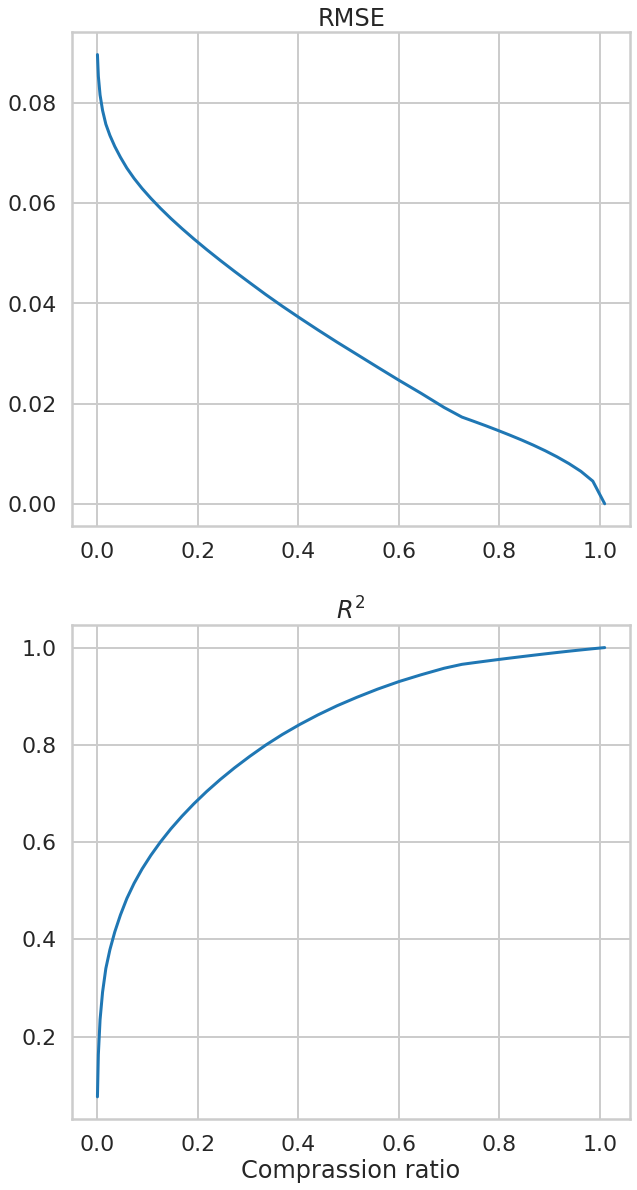

In [88]:
plt.figure(figsize=(10,20))

plt.subplot(211)
plt.plot(compression_ratio_TT, RMSE_TT)
plt.title('RMSE')
ax = plt.gca()


plt.subplot(212)
plt.plot(compression_ratio_TT, r2_TT)
plt.title('$R^2$')
ax = plt.gca()

ax.set_xlabel('Comprassion ratio')

plt.savefig('saved_figure_TT.png')
plt.show()

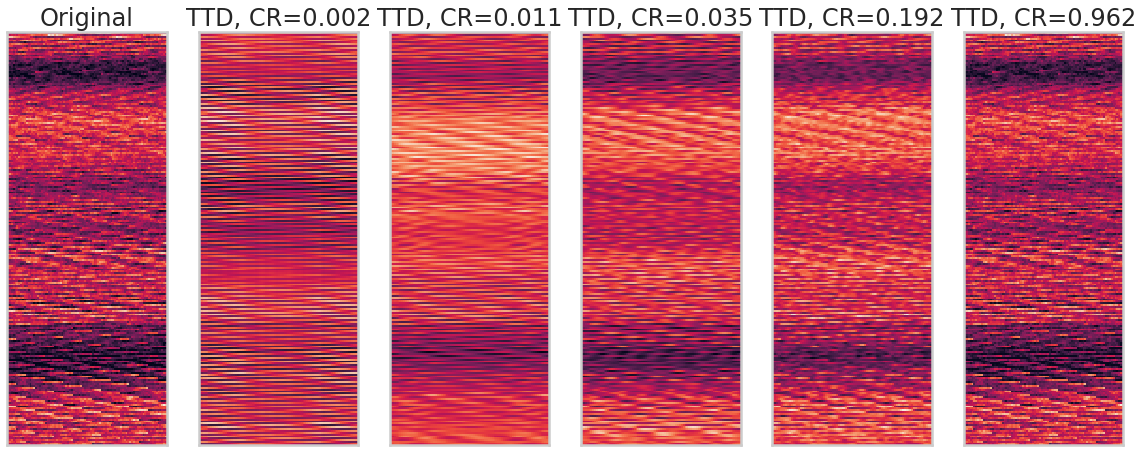

In [87]:
title_str = 'TTD, CR='

plt.figure(figsize=(20,10))

plt.subplot(161)
plt.imshow(poro_tensor[0], interpolation='none')
plt.title('Original')
plt.xticks([])
plt.yticks([])

plt.subplot(162)
plt.imshow(t_mem_TT[1].numpy()[0], interpolation='none')
plt.title(title_str+str(round(compression_ratio_TT[1],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(163)
plt.imshow(t_mem_TT[3].numpy()[0], interpolation='none')
plt.title(title_str+str(round(compression_ratio_TT[3],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(164)
plt.imshow(t_mem_TT[6].numpy()[0], interpolation='none')
plt.title(title_str+str(round(compression_ratio_TT[6],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(165)
plt.imshow(t_mem_TT[15].numpy()[0], interpolation='none')
plt.title(title_str+str(round(compression_ratio_TT[15],3)))
plt.xticks([])
plt.yticks([])

plt.subplot(166)
plt.imshow(t_mem_TT[40].numpy()[0], interpolation='none')
plt.title(title_str+str(round(compression_ratio_TT[40],3)))
plt.xticks([])
plt.yticks([])

plt.show()

## Comparison of results

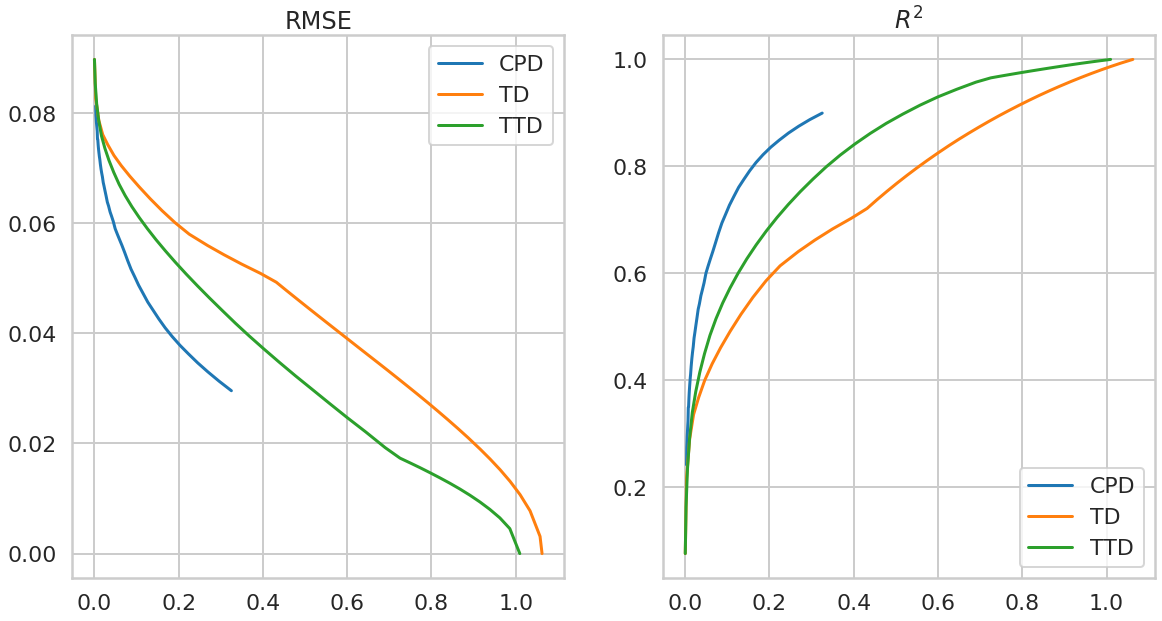

In [89]:
%matplotlib inline

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

plt.figure(figsize=(30,10))


plt.subplot(131)
plt.plot(compression_ratio_CPD, RMSE_CPD)
plt.plot(compression_ratio_TUC, RMSE_TUC)
plt.plot(compression_ratio_TT, RMSE_TT)
plt.title('RMSE')
ax = plt.gca()
ax.legend(['CPD', 'TD', 'TTD'])

plt.subplot(132)
plt.plot(compression_ratio_CPD, r2_CPD)
plt.plot(compression_ratio_TUC, r2_TUC)
plt.plot(compression_ratio_TT, r2_TT)
plt.title('$R^2$')
ax = plt.gca()
ax.legend(['CPD', 'TD', 'TTD'])
ax.legend(['CPD', 'TD', 'TTD'])

plt.suptitle('Comparison of the results obtained for different decomposition types', fontsize = 20, y=1)
plt.savefig('saved_figure.png')
plt.show()